### Notebook to evaluate model convergence on simulated data that incorporates characteristics of our dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import os.path 
import hddm
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
from patsy import center
%matplotlib inline 
cmap = sns.color_palette("hls", 8)
sns.set_palette(cmap)
sns.set_style("white")
import kabuki
from pandas import Series
from patsy import dmatrix

In [2]:
n_subjects = 10
trials_per_level = 150  

In [3]:
level3a = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2a = {'v':2.6, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level1a = {'v':2.2, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}

data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a},
                                                size=trials_per_level,
                                                subjs=n_subjects)

In [4]:
level3b = {'v':1.5, 'a':2, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}
level2b = {'v':2.6, 'a':2, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}
level1b = {'v':2.2, 'a':2, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}

data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
                                                'level2': level2b,
                                                'level3': level3b},
                                                size=trials_per_level,
                                                subjs=n_subjects)

In [5]:
data_a['stimulus'] = Series(np.ones((len(data_a))), index=data_a.index)
data_b['stimulus'] = Series(np.ones((len(data_b)))*2, index=data_a.index)

In [6]:
mydata = data_a.append(data_b, ignore_index=True)
print mydata.head(10)

         rt  response  subj_idx condition  stimulus
0  1.254391       1.0         0    level1       1.0
1  0.475535       1.0         0    level1       1.0
2  0.420486       1.0         0    level1       1.0
3  0.442398       1.0         0    level1       1.0
4  0.622451       1.0         0    level1       1.0
5  0.383813       1.0         0    level1       1.0
6  0.533690       1.0         0    level1       1.0
7  0.401296       1.0         0    level1       1.0
8  0.547361       1.0         0    level1       1.0
9  0.703979       1.0         0    level1       1.0


In [8]:
mydata.to_csv('/home/Projects/scenestats/simulated_data_drift.csv')

Adding these covariates:
['z_Intercept', 'z_C(condition)[T.level2]', 'z_C(condition)[T.level3]']
Adding these covariates:
['v_Intercept', 'v_C(condition)[T.level2]', 'v_C(condition)[T.level3]']
Adding these covariates:
['a_Intercept', 'a_C(condition)[T.level2]', 'a_C(condition)[T.level3]']
 [-----------------100%-----------------] 5001 of 5000 complete in 8690.1 secWARNING: Will not save custom link functions.
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(condition)[T.level2]
Plotting z_C(condition)[T.level3]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(condition)[T.level2]
Plotting v_C(condition)[T.level3]
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_C(condition)[T.level2]
Plotting a_C(condition)[T.level3]


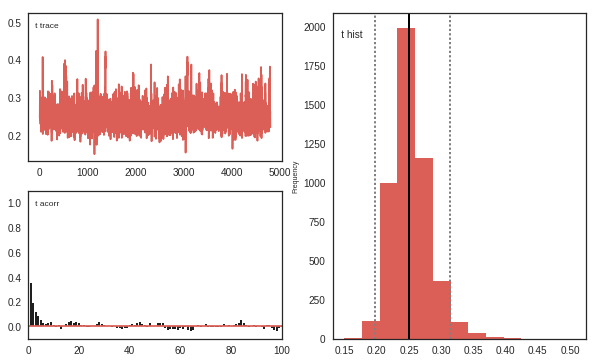

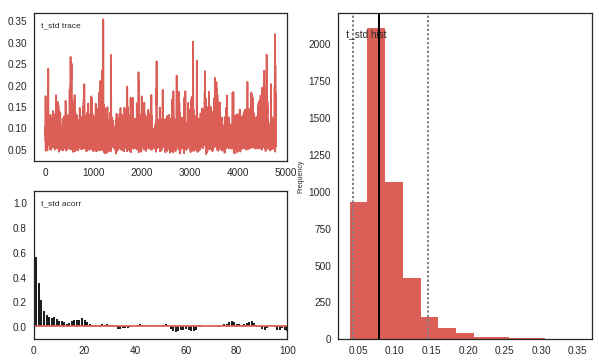

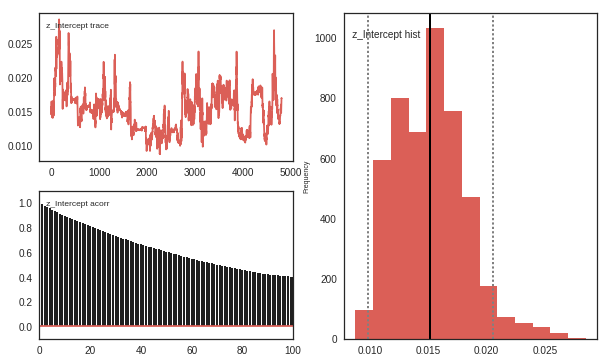

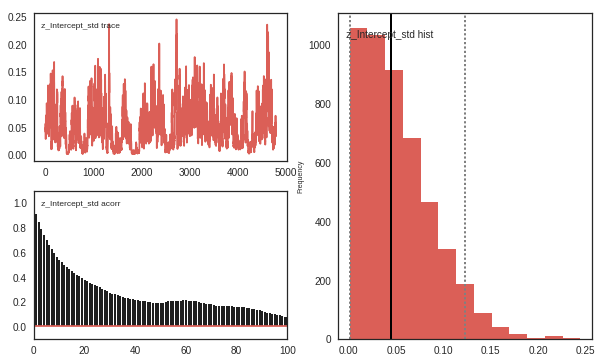

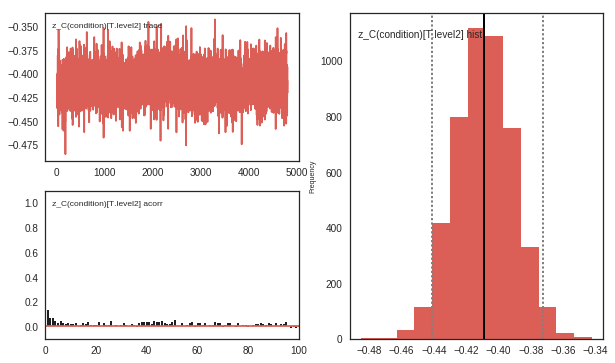

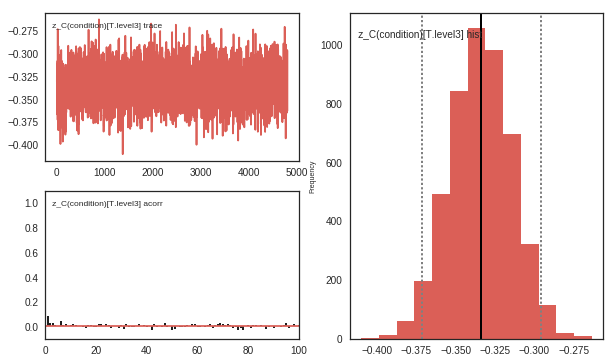

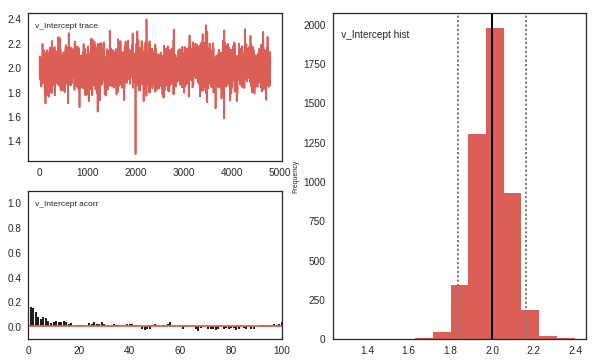

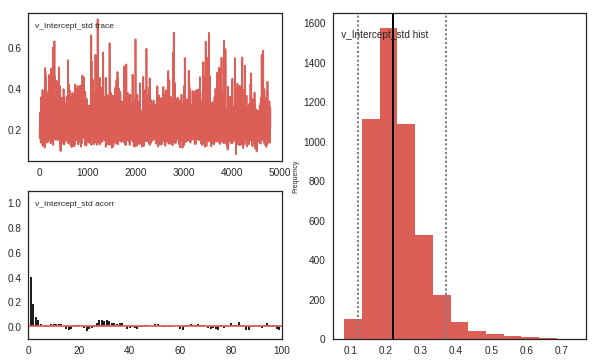

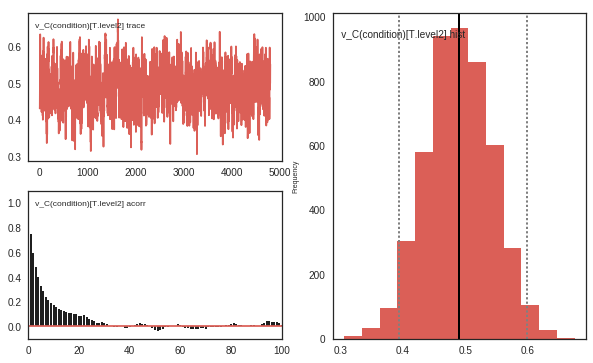

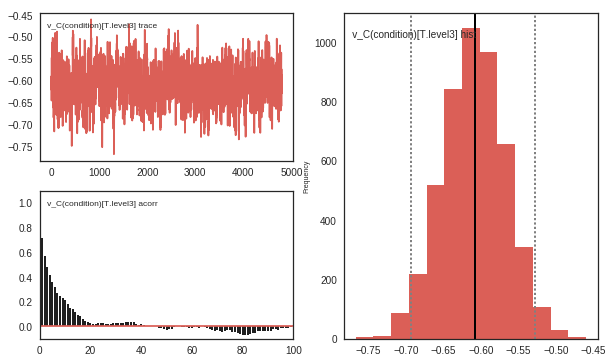

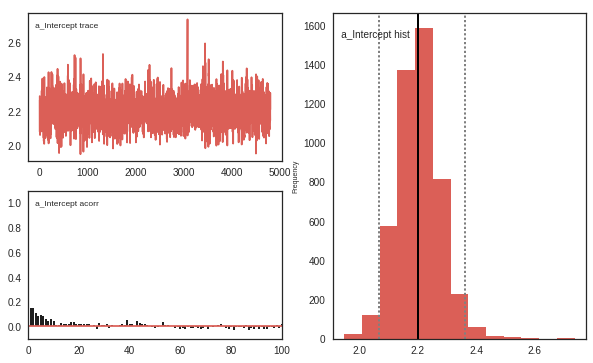

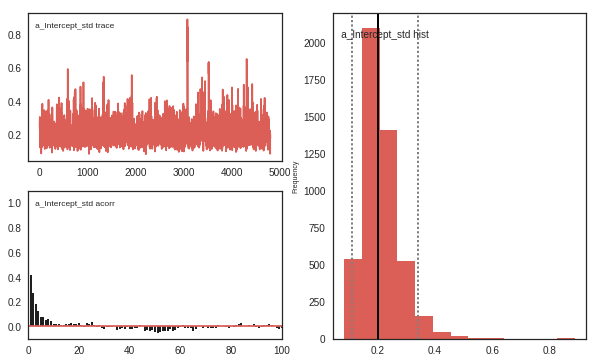

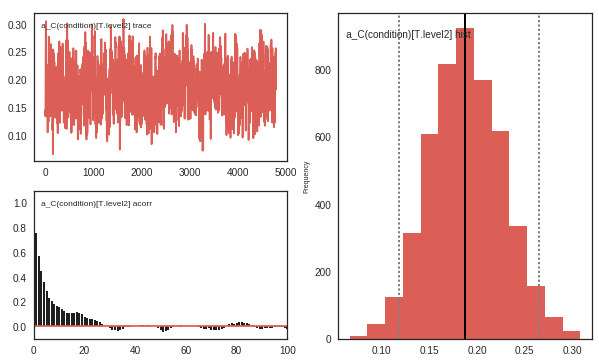

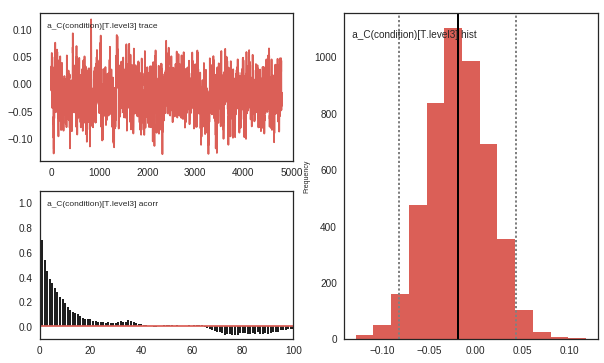

In [9]:
data = hddm.load_csv('/home/Projects/scenestats/simulated_data_drift.csv')

def z_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
    return 1 / (1 + np.exp(-(x * stim)))


z_reg =  {'model': 'z ~ 1 + C(condition)', 'link_func': z_link_func}
v_reg = {'model': 'v ~ 1 + C(condition)', 'link_func': lambda x: x}
a_reg = {'model': 'a ~ 1 + C(condition)', 'link_func': lambda x: x}

os.chdir(u'/home/Projects/scenestats/simulation/drift')
reg_descr = [z_reg, v_reg, a_reg]
m = hddm.HDDMRegressor(data, reg_descr,include='z', p_outlier=0.05)
m.find_starting_values()
m.sample(5000, burn=200, dbname='mtraces_sim_drift.db', db='pickle')

m.save('m')
m.plot_posteriors(save=True)


In [27]:
os.chdir(u'/home/Projects/scenestats/simulation/drift')
model= hddm.load('m')
model.dic

nan

In [28]:
from kabuki.analyze import check_geweke
print check_geweke(model)

AssertionError: Chain of knode_name              t
stochastic           True
observed            False
subj                False
node                    t
tag                    ()
depends                []
hidden              False
Unnamed: 0            NaN
rt                    NaN
response              NaN
subj_idx              NaN
condition             NaN
stimulus              NaN
mean             0.252738
std             0.0302648
2.5q             0.204296
25q              0.232987
50q              0.249228
75q              0.268366
97.5q            0.324186
mc err        0.000747355
Name: t, dtype: object not properly converged

Even though model did not converge, let's look at the means of the posterior distribution 

In [29]:
model.print_stats('model_printstats.txt') #print stats + dic 
model.gen_stats('model_stats.txt') # point estimates only
model_group_reg_stats = model.gen_stats()

z_Intercept = model.nodes_db.node[['z_Intercept']].mean()
z_TB = model.nodes_db.node[['z_C(condition)[T.level2]']].mean()
z_TC = model.nodes_db.node[['z_C(condition)[T.level3]']].mean()
z_A = round(1/(1+np.exp(-(np.float(z_Intercept)))),3)
z_B = round(1/(1+np.exp(-(np.float(z_Intercept)+np.float(z_TB)))),3)
z_C = round(1/(1+np.exp(-(np.float(z_Intercept)+np.float(z_TC)))),3)

print "starting points estimated for low: ", z_A,"med: ", z_B," and high: ", z_C

v_Intercept = model.nodes_db.node[['v_Intercept']].mean()
v_TB = model.nodes_db.node[['v_C(condition)[T.level2]']].mean()
v_TC = model.nodes_db.node[['v_C(condition)[T.level3]']].mean()
v_A = round(v_Intercept,3)
v_B = round(v_TB,3)
v_C = round(v_TC,3)

print "drift rates points estimated for low: ", v_A,"med: ", v_A+v_B," and high: ", v_A+v_C

a_Intercept = model.nodes_db.node[['a_Intercept']].mean()
a_TB = model.nodes_db.node[['a_C(condition)[T.level2]']].mean()
a_TC = model.nodes_db.node[['a_C(condition)[T.level3]']].mean()
a_A = round(a_Intercept,3)
a_B = round(a_TB,3)
a_C = round(a_TC,3)

print "response boundary for low: ", a_A,"med: ", a_A+a_B," and high: ", a_A+a_C

starting points estimated for low:  0.504 med:  0.403  and high:  0.421
drift rates points estimated for low:  2.0 med:  2.489  and high:  1.391
response boundary for low:  2.203 med:  2.392  and high:  2.185


### See whether this simulated data resembles our data in terms of RTs and % errors:

In [30]:
df2 = pd.pivot_table(data, values=['rt', 'response'], columns=['condition'], index=mydata.subj_idx, aggfunc='mean')

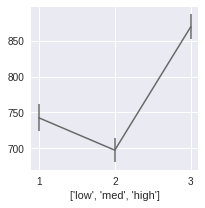

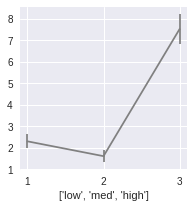

In [131]:
data4rt = mydata[mydata['response'] == 1]# remove error trials for RT analysis (correct = 1, error = 0)
data4rt['rt'] = data4rt['rt'].apply(pd.to_numeric)*1000 #RT in ms

#RTs - repeated measures ANOVA with complexity (low, med, high) and instruction (speed, accurate)
means = data4rt.groupby(['subj_idx', 'condition'], as_index=False)['rt'].mean()
means['rt'] = means['rt'].round(3) 

fig = plt.figure(figsize =(3,3))
plt.xticks([1,2,3])
plt.xlabel(['low','med', 'high'])
ax = plt.errorbar([1,2,3],means.groupby('condition')['rt'].mean(), means.groupby('condition')['rt'].sem(),fmt='-o',markersize= 0.5, color='dimgrey', linewidth=1.5)

totalT = mydata.groupby(['subj_idx', 'condition'], as_index=False)['response'].count()
correctT = mydata.groupby(['subj_idx', 'condition'], as_index=False)['response'].sum()
totalT['response'] = (1-(correctT['response']/totalT['response'].round(3)))*100

fig = plt.figure(figsize =(3,3))
plt.xticks([1,2,3])
plt.xlabel(['low','med', 'high'])
ax = plt.errorbar([1,2,3],totalT.groupby('condition')['response'].mean(), totalT.groupby('condition')['response'].sem(), fmt='-o',markersize= 0.5, color='grey')


**Try again, with longer chain and more burn-in and thinning**

In [ ]:
data = hddm.load_csv('/home/Projects/scenestats/simulated_data_drift.csv')

def z_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
    return 1 / (1 + np.exp(-(x * stim)))


z_reg =  {'model': 'z ~ 1 + C(condition)', 'link_func': z_link_func}
v_reg = {'model': 'v ~ 1 + C(condition)', 'link_func': lambda x: x}
a_reg = {'model': 'a ~ 1 + C(condition)', 'link_func': lambda x: x}

os.chdir(u'/home/Projects/scenestats/revision_SciRep/simulation/drift_longerchain')
reg_descr = [z_reg, v_reg, a_reg]
m = hddm.HDDMRegressor(data, reg_descr,include='z', p_outlier=0.05)
m.find_starting_values()
m.sample(10000, burn=5000, thin=2, dbname='mtraces_sim_driftl.db', db='pickle')

m.save('m')
m.plot_posteriors(save=True)


Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(condition)[T.level2]
Plotting z_C(condition)[T.level3]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(condition)[T.level2]
Plotting v_C(condition)[T.level3]
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_C(condition)[T.level2]
Plotting a_C(condition)[T.level3]


nan

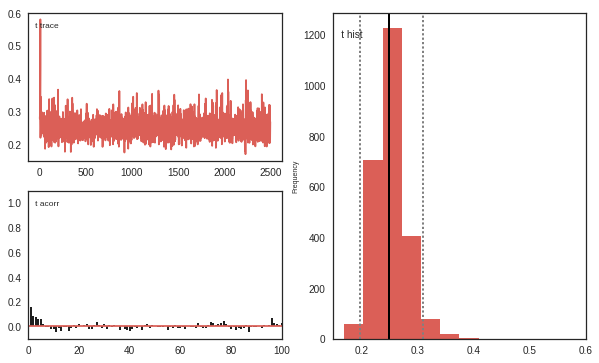

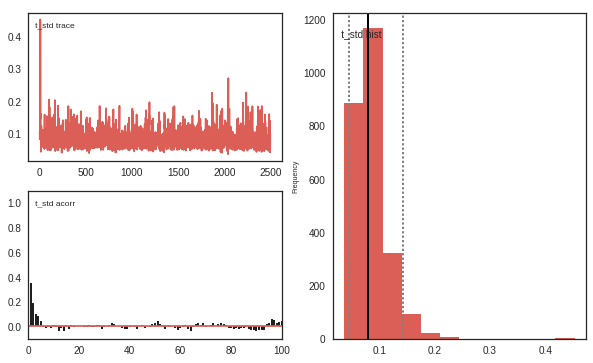

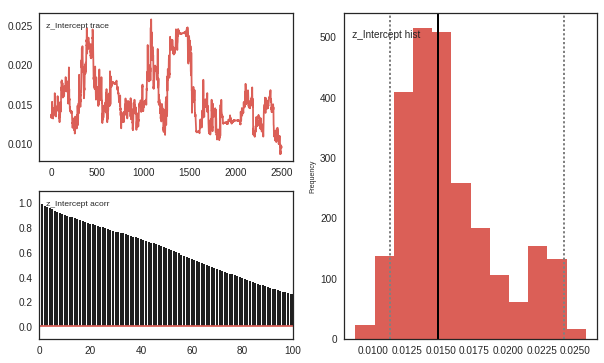

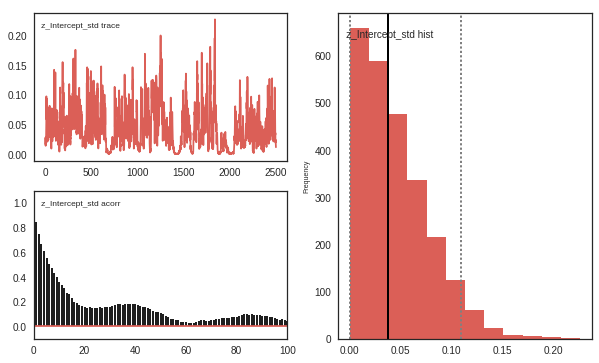

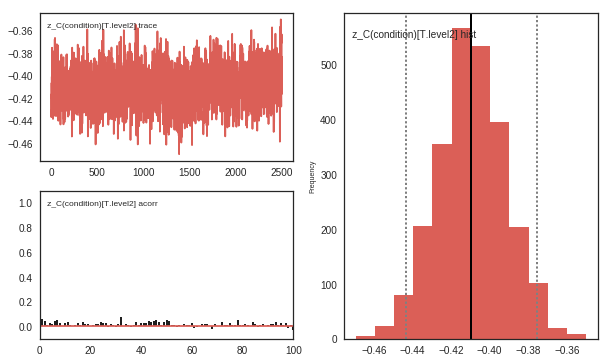

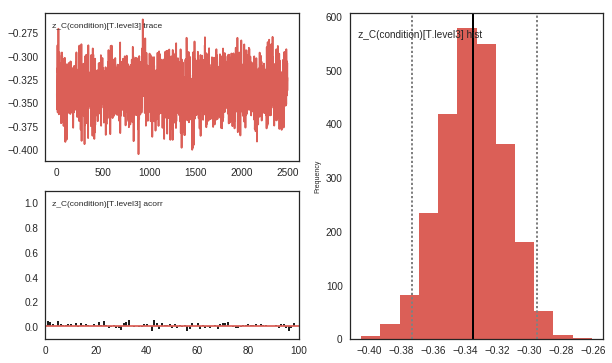

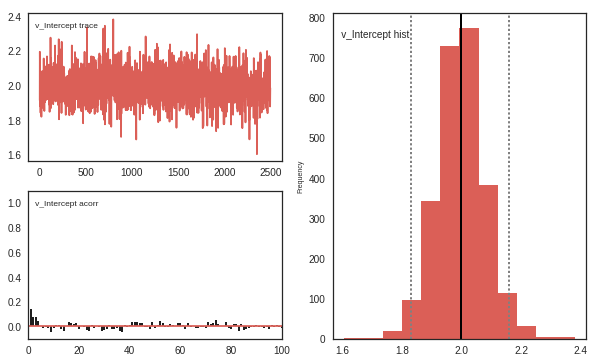

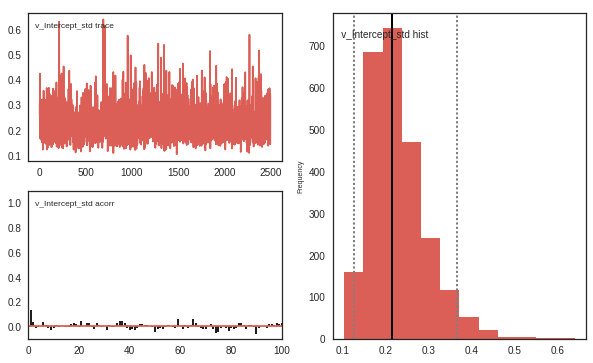

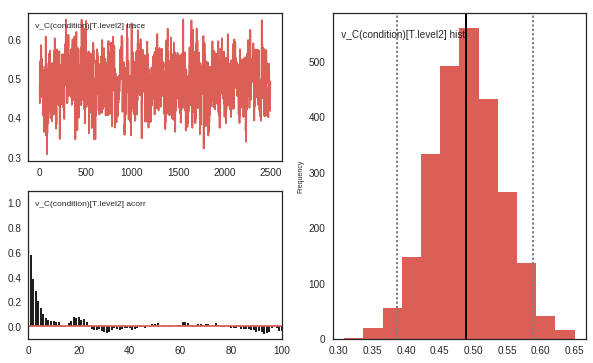

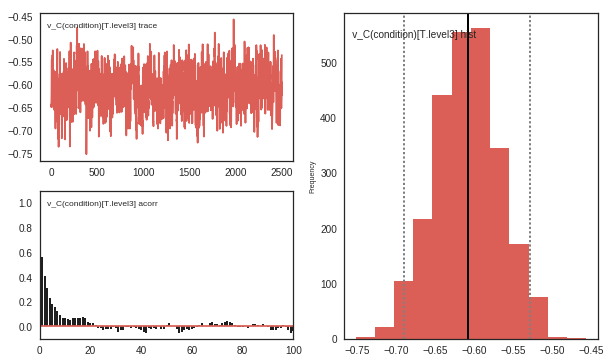

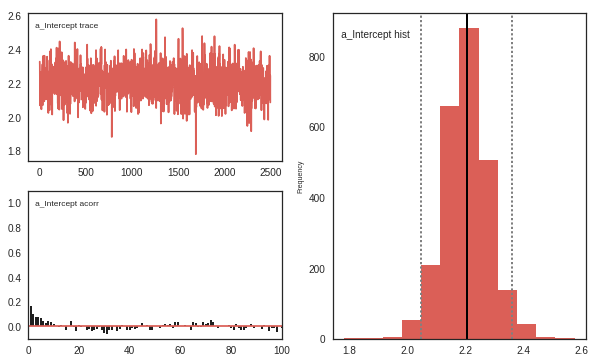

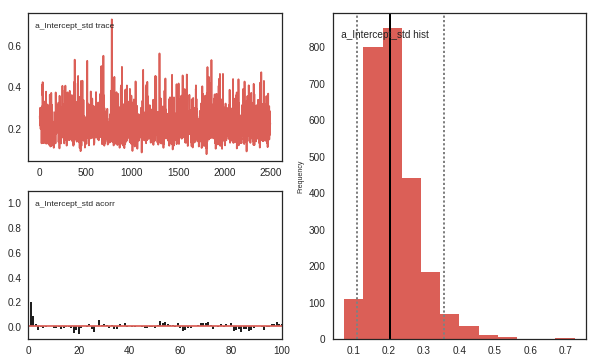

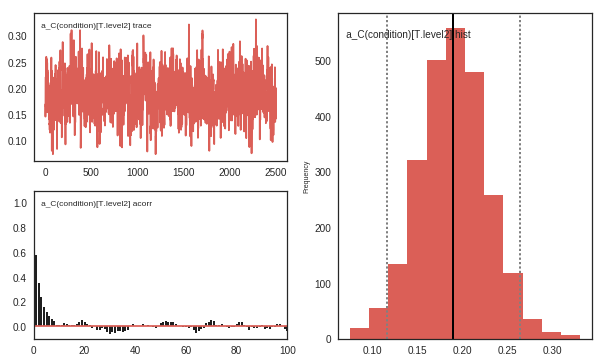

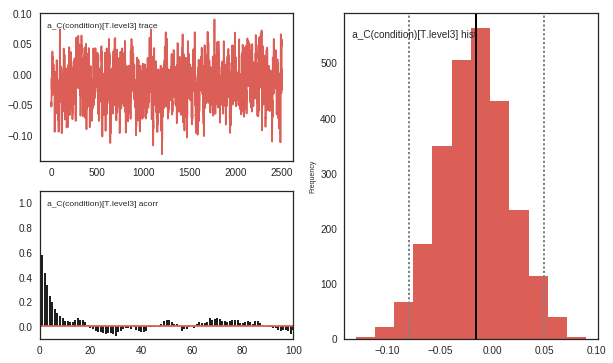

In [19]:
os.chdir(u'/home/nseijde1/Projects/scenestats/revision_SciRep/simulation/drift_longerchain')
model= hddm.load('m')
model.plot_posteriors()
model.dic

**2. Simulation in which drift rate and boundary are allowed to vary**

In [7]:
level3a = {'v':1.5, 'a':1.8, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2a = {'v':2.6, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level1a = {'v':2.2, 'a':2.2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}

data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a},
                                                size=trials_per_level,
                                                subjs=n_subjects)

In [8]:
level3b = {'v':1.5, 'a':1.8, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}
level2b = {'v':2.6, 'a':2, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}
level1b = {'v':2.2, 'a':2.2, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}

data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
                                                'level2': level2b,
                                                'level3': level3b},
                                                size=trials_per_level,
                                                subjs=n_subjects)

In [9]:
data_a['stimulus'] = Series(np.ones((len(data_a))), index=data_a.index)
data_b['stimulus'] = Series(np.ones((len(data_b)))*2, index=data_a.index)

In [10]:
mydata = data_a.append(data_b, ignore_index=True)

In [11]:
mydata.head(10)

,rt,response,subj_idx,condition,stimulus
0,0.491180,1.0,0,level1,1.0
1,1.260195,1.0,0,level1,1.0
2,1.491295,1.0,0,level1,1.0
3,0.540311,1.0,0,level1,1.0
4,0.690445,1.0,0,level1,1.0
5,0.548022,1.0,0,level1,1.0
6,0.501368,1.0,0,level1,1.0
7,0.726969,1.0,0,level1,1.0
8,0.791172,1.0,0,level1,1.0
9,0.663660,1.0,0,level1,1.0


In [16]:
mydata.to_csv('/home/Projects/scenestats/simulated_data_drift_boundary.csv')

Adding these covariates:
['z_Intercept', 'z_C(condition)[T.level2]', 'z_C(condition)[T.level3]']
Adding these covariates:
['v_Intercept', 'v_C(condition)[T.level2]', 'v_C(condition)[T.level3]']
Adding these covariates:
['a_Intercept', 'a_C(condition)[T.level2]', 'a_C(condition)[T.level3]']
 [-----------------100%-----------------] 5001 of 5000 complete in 7958.5 secWARNING: Will not save custom link functions.
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(condition)[T.level2]
Plotting z_C(condition)[T.level3]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(condition)[T.level2]
Plotting v_C(condition)[T.level3]
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_C(condition)[T.level2]
Plotting a_C(condition)[T.level3]


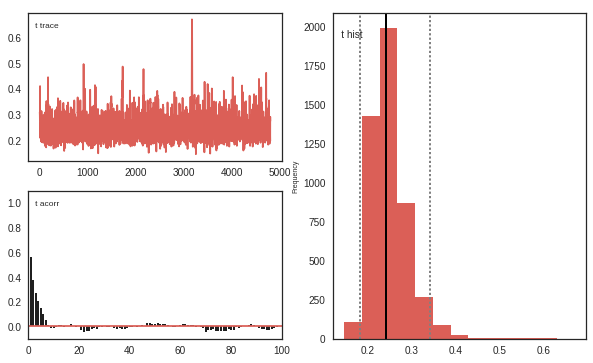

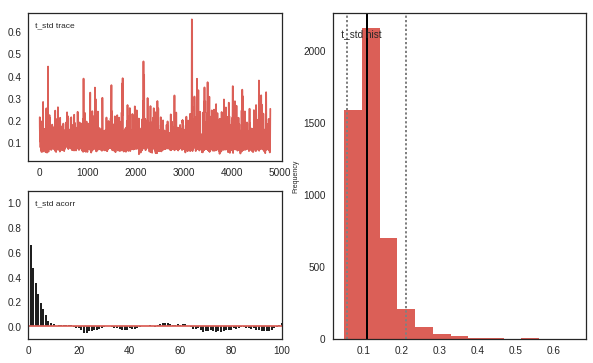

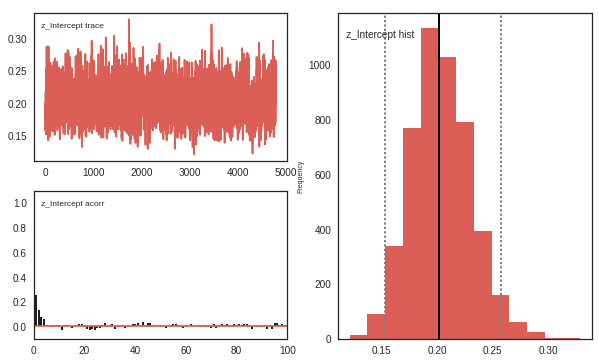

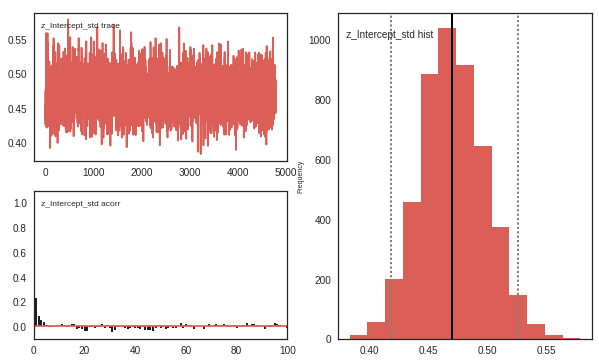

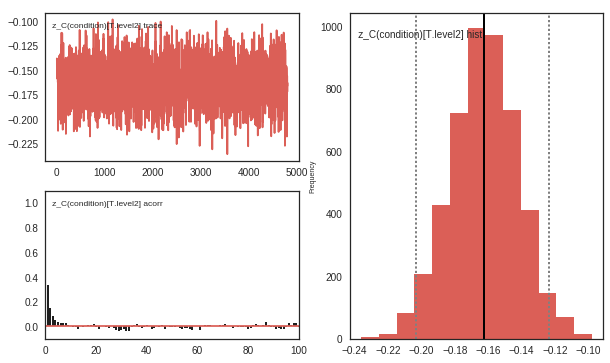

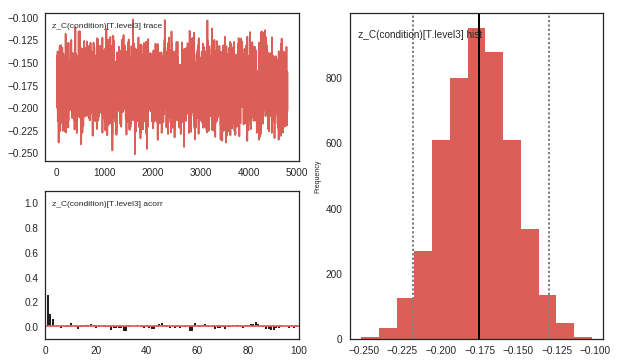

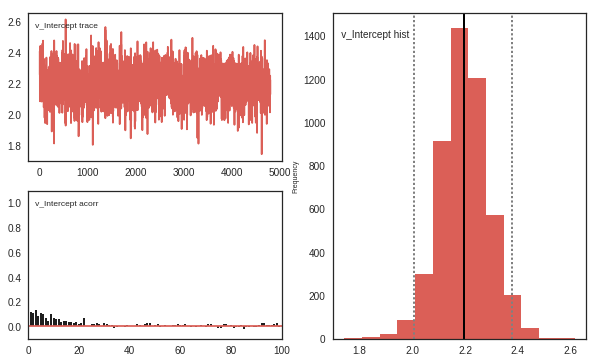

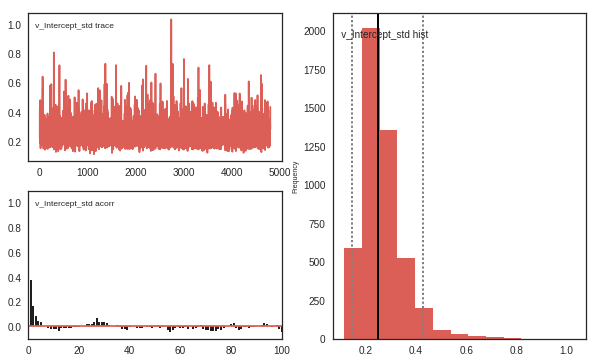

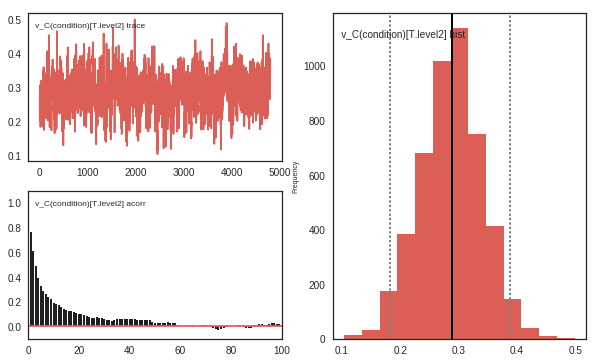

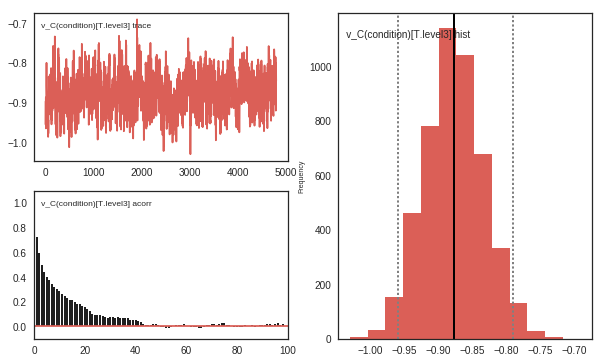

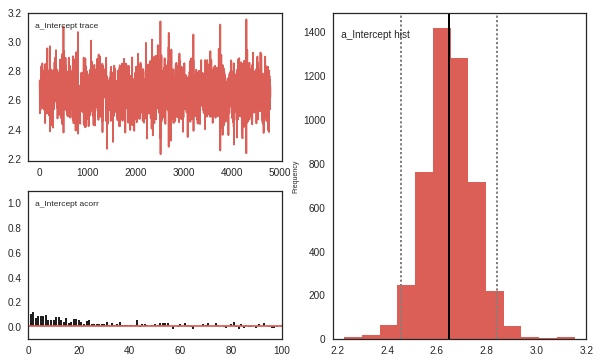

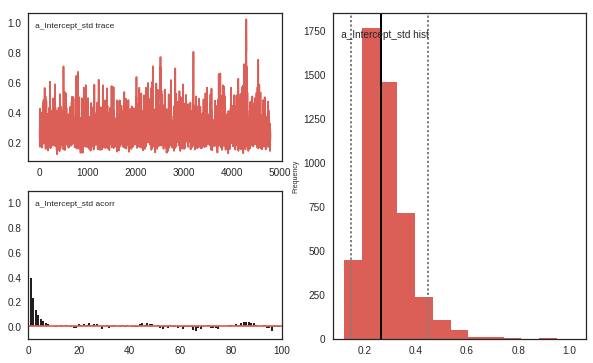

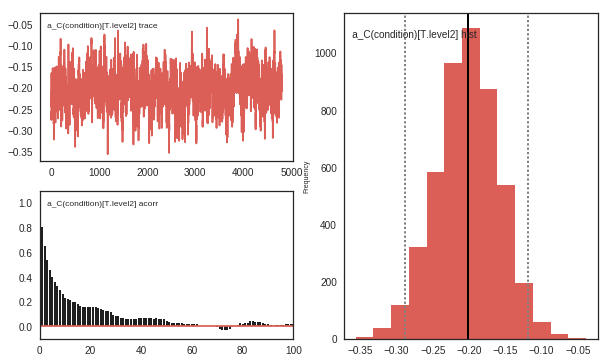

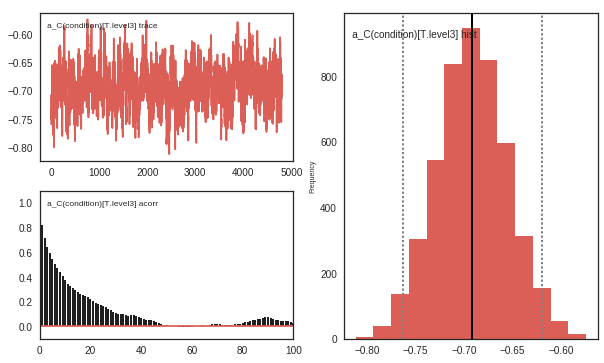

In [17]:
data = hddm.load_csv('/home/Projects/scenestats/simulated_data_drift_boundary.csv')

def z_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
    return 1 / (1 + np.exp(-(x * stim)))


z_reg =  {'model': 'z ~ 1 + C(condition)', 'link_func': z_link_func}
v_reg = {'model': 'v ~ 1 + C(condition)', 'link_func': lambda x: x}
a_reg = {'model': 'a ~ 1 + C(condition)', 'link_func': lambda x: x}

os.chdir(u'/home/Projects/scenestats/simulation/drift_boundary')
reg_descr = [z_reg, v_reg, a_reg]
m = hddm.HDDMRegressor(data, reg_descr,include='z', p_outlier=0.05)
m.find_starting_values()
m.sample(5000, burn=200, dbname='mtraces_sim_driftboundary.db', db='pickle')

m.save('m')
m.plot_posteriors(save=True)


In [18]:
os.chdir(u'/home/Projects/scenestats/simulation/drift_boundary')
model= hddm.load('m')
model.dic

nan

**3. Simulation in which drift rate and starting point are allowed to vary**

In [12]:
level3a = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2a = {'v':2.6, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level1a = {'v':2.2, 'a':2, 't':.3, 'sv':0, 'z':.3, 'sz':0, 'st':0}

data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a},
                                                size=trials_per_level,
                                                subjs=n_subjects)

In [13]:
level3b = {'v':1.5, 'a':2, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}
level2b = {'v':2.6, 'a':2, 't':.3,'sv': 0, 'z':.6, 'sz': 0, 'st': 0}
level1b = {'v':2.2, 'a':2, 't':.3,'sv': 0, 'z':.7, 'sz': 0, 'st': 0}

data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
                                                'level2': level2b,
                                                'level3': level3b},
                                                size=trials_per_level,
                                                subjs=n_subjects)

In [14]:
data_a['stimulus'] = Series(np.ones((len(data_a))), index=data_a.index)
data_b['stimulus'] = Series(np.ones((len(data_b)))*2, index=data_a.index)

In [15]:
mydata = data_a.append(data_b, ignore_index=True)

In [16]:
mydata.head(10)

,rt,response,subj_idx,condition,stimulus
0,0.589122,1.0,0,level1,1.0
1,0.837329,1.0,0,level1,1.0
2,0.942354,1.0,0,level1,1.0
3,0.519328,1.0,0,level1,1.0
4,0.826333,1.0,0,level1,1.0
5,0.689488,1.0,0,level1,1.0
6,0.665318,1.0,0,level1,1.0
7,1.007208,1.0,0,level1,1.0
8,0.578854,1.0,0,level1,1.0
9,1.372832,1.0,0,level1,1.0


In [24]:
mydata.to_csv('/home/Projects/scenestats/simulated_data_drift_startingpoint.csv')

Adding these covariates:
['z_Intercept', 'z_C(condition)[T.level2]', 'z_C(condition)[T.level3]']
Adding these covariates:
['v_Intercept', 'v_C(condition)[T.level2]', 'v_C(condition)[T.level3]']
Adding these covariates:
['a_Intercept', 'a_C(condition)[T.level2]', 'a_C(condition)[T.level3]']
 [-----------------100%-----------------] 5001 of 5000 complete in 7924.3 secWARNING: Will not save custom link functions.
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(condition)[T.level2]
Plotting z_C(condition)[T.level3]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(condition)[T.level2]
Plotting v_C(condition)[T.level3]
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_C(condition)[T.level2]
Plotting a_C(condition)[T.level3]


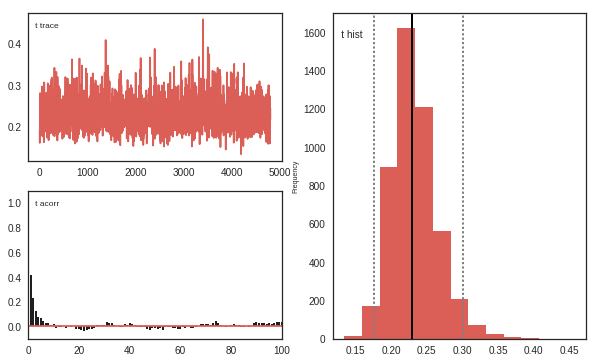

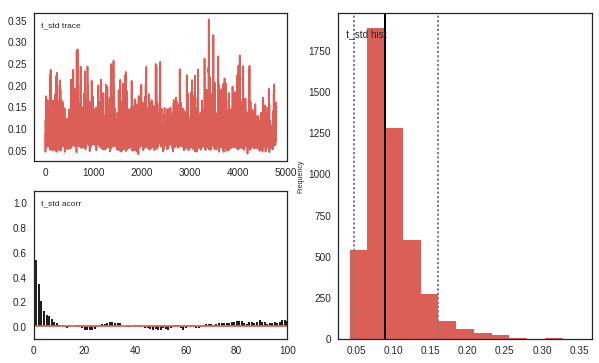

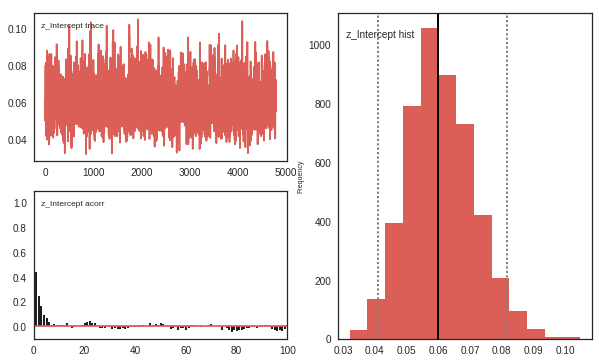

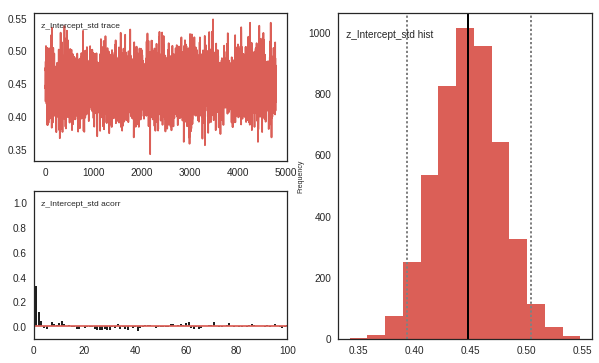

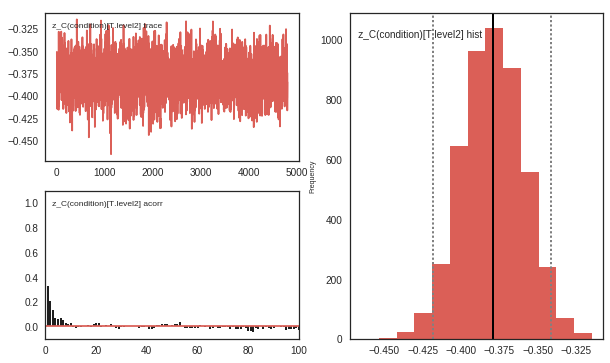

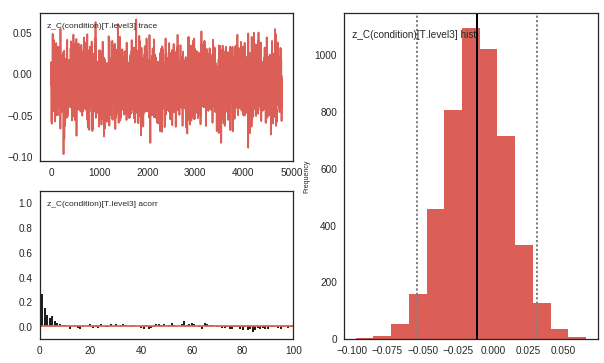

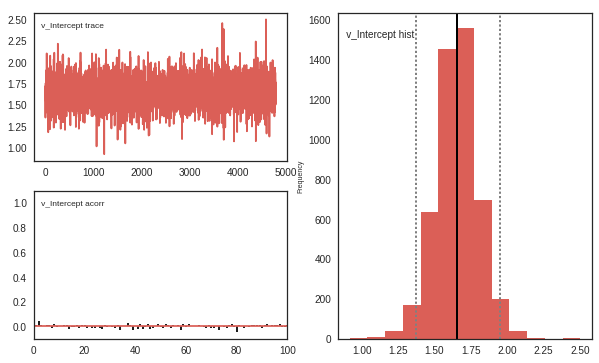

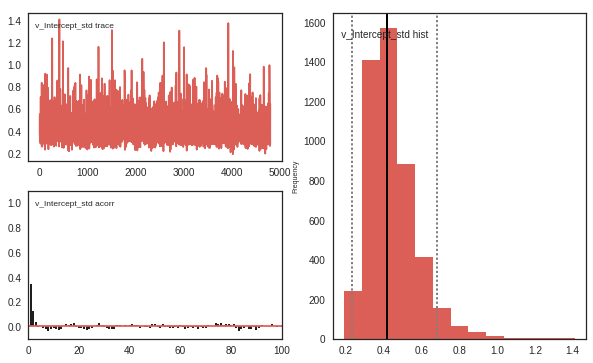

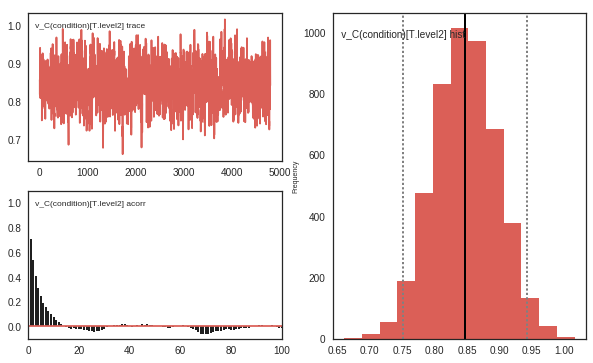

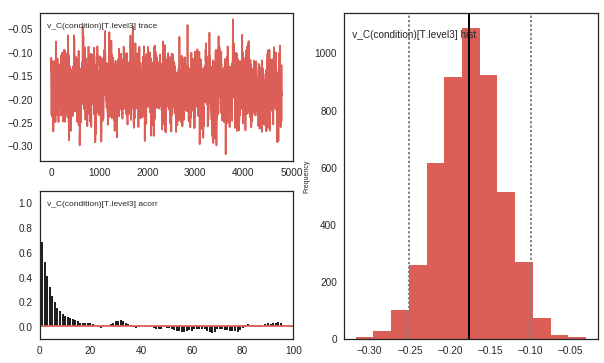

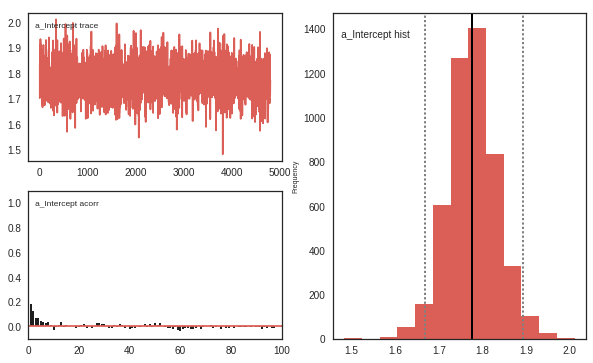

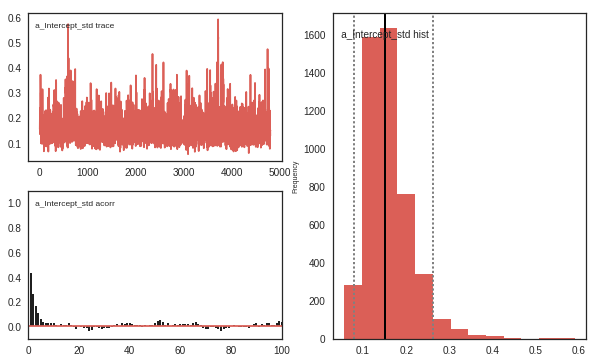

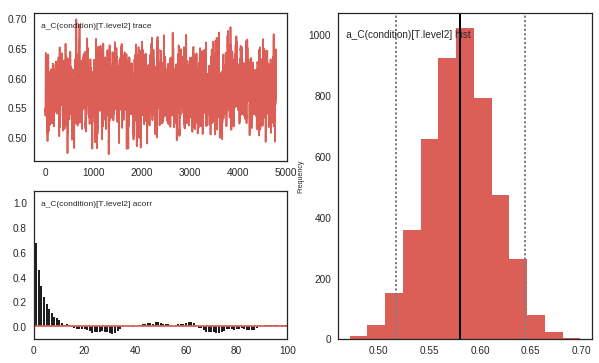

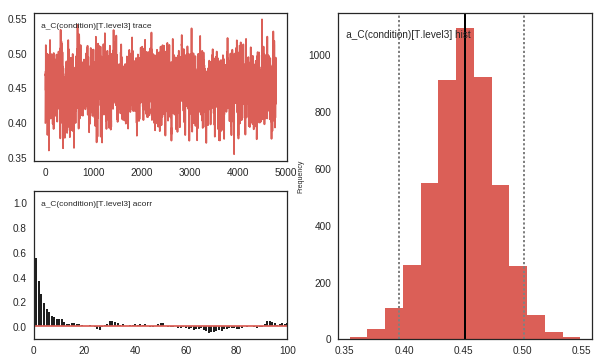

In [25]:
data = hddm.load_csv('/home/Projects/scenestats/simulated_data_drift_startingpoint.csv')

def z_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ix[x.index]})))
    return 1 / (1 + np.exp(-(x * stim)))


z_reg =  {'model': 'z ~ 1 + C(condition)', 'link_func': z_link_func}
v_reg = {'model': 'v ~ 1 + C(condition)', 'link_func': lambda x: x}
a_reg = {'model': 'a ~ 1 + C(condition)', 'link_func': lambda x: x}

os.chdir(u'/home/Projects/scenestats/simulation/drift_startingpoint')
reg_descr = [z_reg, v_reg, a_reg]
m = hddm.HDDMRegressor(data, reg_descr,include='z', p_outlier=0.05)
m.find_starting_values()
m.sample(5000, burn=200, dbname='mtraces_sim_drift_startingpoint.db', db='pickle')

m.save('m')
m.plot_posteriors(save=True)


In [26]:
os.chdir(u'/home/Projects/scenestats/simulation/drift_startingpoint')
model= hddm.load('m')
model.dic

nan